In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm

from datasets import load_dataset, Dataset, load_from_disk, concatenate_datasets, DatasetDict
from transformers import AutoTokenizer, AutoModelForCausalLM

/home/pedram/miniconda3/envs/echo-llm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Tokenizing the dataset
token = "YOUR_TOKEN_HERE"


MODEL_TAG="meta-llama/Llama-3.2-1B"
# MODEL_TAG="deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
# MODEL_TAG="google/gemma-3-1b-pt"
tokenizer = AutoTokenizer.from_pretrained(MODEL_TAG,
                                          cache_dir='./model_cache_dir',
                                          return_dict=True,
                                          token=token,
                                          )
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"


In [3]:
# Tokenizing the dataset
def tokenize_function(examples):
    tokenized = tokenizer(examples["text"])
    return {"input_ids": tokenized["input_ids"]}

# KL-divergence calculation
def token_distribution(tokens):
    token_counts = np.bincount(tokens, minlength=tokenizer.vocab_size)
    return token_counts / np.sum(token_counts)

def kl_divergence(p, q):
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    p = p / np.sum(p)
    q = q / np.sum(q)

    # Avoid division by zero and log(0) issues
    p = np.where(p == 0, 1e-10, p)
    q = np.where(q == 0, 1e-10, q)
    return np.sum(p * np.log(p / q))

def kl_divergence_synthetic(dataset_path):
    kl_divs = []
    for i in range(6):
        dataset_file = dataset_path + f"stage{i}.txt"
        synthetic_dataset = load_dataset("text", data_files={"train": [dataset_file]})
        tokenized_synthetic = synthetic_dataset.map(tokenize_function,
                                                    batched=True,
                                                    num_proc=64,
                                                    desc="Running tokenizer on dataset",
                                                    keep_in_memory=True,)

        tokens_synthetic = tokenized_synthetic["train"]["input_ids"]
        all_tokens_synthetic = [token for sublist in tokens_synthetic for token in sublist]
        print(f"Total tokens: {len(all_tokens_synthetic)}")

        synthetic_distribution = token_distribution(all_tokens_synthetic)

        kl_div = kl_divergence(synthetic_distribution, wikitext_distribution)
        kl_divs.append(kl_div)
        print(f"KL Divergence between synthetic and wikitext distributions: {kl_div}")
    return kl_divs

wikitext_dataset = load_from_disk("./data/wikitext2")
tokenized_wikitext = wikitext_dataset.map(tokenize_function,
                                          batched=True,
                                          num_proc=64,
                                          desc="Running tokenizer on dataset",
                                          keep_in_memory=True,)


tokens_wikitext = tokenized_wikitext["train"]["input_ids"]
all_tokens_wikitext = [token for sublist in tokens_wikitext for token in sublist]
print(f"Total tokens in wikitext: {len(all_tokens_wikitext)}")
wikitext_distribution = token_distribution(all_tokens_wikitext)

Running tokenizer on dataset (num_proc=64): 100%|██████████| 3760/3760 [00:00<00:00, 3932.88 examples/s]


Total tokens in wikitext: 2471740


In [4]:
# LLama
llama_baseline = kl_divergence_synthetic("/scr/echollm/generated_datasets/llama-1b/focal_0.0/frac_6/batch64-lr2e-5-seed10-20250329015720/")
llama_focal  = kl_divergence_synthetic("/scr/echollm/generated_datasets/llama-1b/focal_2.0/frac_6//batch64-lr2e-5-seed10-20250329013610/")
llama_tce_9    = kl_divergence_synthetic("/scr/echollm/generated_datasets/AWS/TCE0.9/")
llama_tce_99   = kl_divergence_synthetic("/scr/echollm/generated_datasets/AWS/TCE0.99/")



# Gemma
# gemma_baseline = kl_divergence_synthetic("/scr/echollm/generated_datasets/llama-1b/focal_0.0/frac_6/batch64-lr2e-5-seed1-20250522190804/")
# gemma_focal    = kl_divergence_synthetic("/scr/echollm/generated_datasets/llama-1b/focal_2.0/frac_6/batch64-lr2e-5-seed1-20250522183909/")
# gemma_tce_9    = kl_divergence_synthetic("/scr/echollm/generated_datasets/llama-1b/clipped_0.9/frac_6/batch64-lr2e-5-seed1-20250526052904/")
# gemma_tce_99   = kl_divergence_synthetic("/scr/echollm/generated_datasets/llama-1b/clipped_0.99/frac_6/batch64-lr2e-5-seed1-20250527172556/")

Running tokenizer on dataset (num_proc=64): 100%|██████████| 3685/3685 [00:01<00:00, 3238.47 examples/s]


Total tokens: 410339
KL Divergence between synthetic and wikitext distributions: 0.8594168437171618


Running tokenizer on dataset (num_proc=64): 100%|██████████| 3941/3941 [00:02<00:00, 1829.97 examples/s]


Total tokens: 821637
KL Divergence between synthetic and wikitext distributions: 0.8313359395883505


Running tokenizer on dataset (num_proc=64): 100%|██████████| 1697/1697 [00:03<00:00, 521.52 examples/s] 


Total tokens: 1229246
KL Divergence between synthetic and wikitext distributions: 0.8239462103722786


Running tokenizer on dataset (num_proc=64): 100%|██████████| 2984/2984 [00:04<00:00, 644.80 examples/s] 


Total tokens: 1637894
KL Divergence between synthetic and wikitext distributions: 0.8859868799664903


Running tokenizer on dataset (num_proc=64): 100%|██████████| 3087/3087 [00:06<00:00, 490.32 examples/s] 


Total tokens: 2047058
KL Divergence between synthetic and wikitext distributions: 1.0152997146424088


Running tokenizer on dataset (num_proc=64): 100%|██████████| 2105/2105 [00:06<00:00, 303.82 examples/s] 


Total tokens: 2454887
KL Divergence between synthetic and wikitext distributions: 1.2369220093683728


Running tokenizer on dataset (num_proc=64): 100%|██████████| 3250/3250 [00:01<00:00, 2974.16 examples/s]


Total tokens: 410179
KL Divergence between synthetic and wikitext distributions: 0.8558965949019192


Running tokenizer on dataset (num_proc=64): 100%|██████████| 2897/2897 [00:01<00:00, 1461.23 examples/s]


Total tokens: 819447
KL Divergence between synthetic and wikitext distributions: 0.8092382802454222


Running tokenizer on dataset (num_proc=64): 100%|██████████| 3231/3231 [00:03<00:00, 1004.25 examples/s]


Total tokens: 1229224
KL Divergence between synthetic and wikitext distributions: 0.8006263188057863


Running tokenizer on dataset (num_proc=64): 100%|██████████| 3259/3259 [00:05<00:00, 643.49 examples/s] 


Total tokens: 1638505
KL Divergence between synthetic and wikitext distributions: 0.8469333075520946


Running tokenizer on dataset (num_proc=64): 100%|██████████| 2362/2362 [00:04<00:00, 475.85 examples/s] 


Total tokens: 2048025
KL Divergence between synthetic and wikitext distributions: 0.981011746313622


Running tokenizer on dataset (num_proc=64): 100%|██████████| 2152/2152 [00:06<00:00, 309.57 examples/s] 


Total tokens: 2457034
KL Divergence between synthetic and wikitext distributions: 1.1148433705209373


Running tokenizer on dataset (num_proc=64): 100%|██████████| 3649/3649 [00:01<00:00, 3156.24 examples/s]


Total tokens: 410619
KL Divergence between synthetic and wikitext distributions: 0.8249102271945078


Running tokenizer on dataset (num_proc=64): 100%|██████████| 1920/1920 [00:02<00:00, 761.15 examples/s] 


Total tokens: 819288
KL Divergence between synthetic and wikitext distributions: 0.7877613701190082


Running tokenizer on dataset (num_proc=64): 100%|██████████| 2954/2954 [00:03<00:00, 854.37 examples/s] 


Total tokens: 1227948
KL Divergence between synthetic and wikitext distributions: 0.8065056571599543


Running tokenizer on dataset (num_proc=64): 100%|██████████| 4128/4128 [00:04<00:00, 906.21 examples/s] 


Total tokens: 1638123
KL Divergence between synthetic and wikitext distributions: 0.8067148554600686


Running tokenizer on dataset (num_proc=64): 100%|██████████| 6521/6521 [00:06<00:00, 1019.24 examples/s]


Total tokens: 2050667
KL Divergence between synthetic and wikitext distributions: 0.954225436496823


Running tokenizer on dataset (num_proc=64): 100%|██████████| 5214/5214 [00:08<00:00, 616.54 examples/s] 


Total tokens: 2462309
KL Divergence between synthetic and wikitext distributions: 1.3414743779381437


Running tokenizer on dataset (num_proc=64): 100%|██████████| 3839/3839 [00:01<00:00, 3558.54 examples/s]


Total tokens: 410762
KL Divergence between synthetic and wikitext distributions: 0.8192147858050548


Running tokenizer on dataset (num_proc=64): 100%|██████████| 2300/2300 [00:01<00:00, 1259.80 examples/s]


Total tokens: 819572
KL Divergence between synthetic and wikitext distributions: 0.7787748532901004


Running tokenizer on dataset (num_proc=64): 100%|██████████| 2450/2450 [00:03<00:00, 792.12 examples/s] 


Total tokens: 1227933
KL Divergence between synthetic and wikitext distributions: 0.7704256706250308


Running tokenizer on dataset (num_proc=64): 100%|██████████| 2334/2334 [00:06<00:00, 382.36 examples/s] 


Total tokens: 1636092
KL Divergence between synthetic and wikitext distributions: 0.7640537085477148


Running tokenizer on dataset (num_proc=64): 100%|██████████| 4924/4924 [00:05<00:00, 877.33 examples/s] 


Total tokens: 2047115
KL Divergence between synthetic and wikitext distributions: 0.7582104184811024


Running tokenizer on dataset (num_proc=64): 100%|██████████| 3745/3745 [00:06<00:00, 603.18 examples/s] 


Total tokens: 2455677
KL Divergence between synthetic and wikitext distributions: 0.7642697591905149


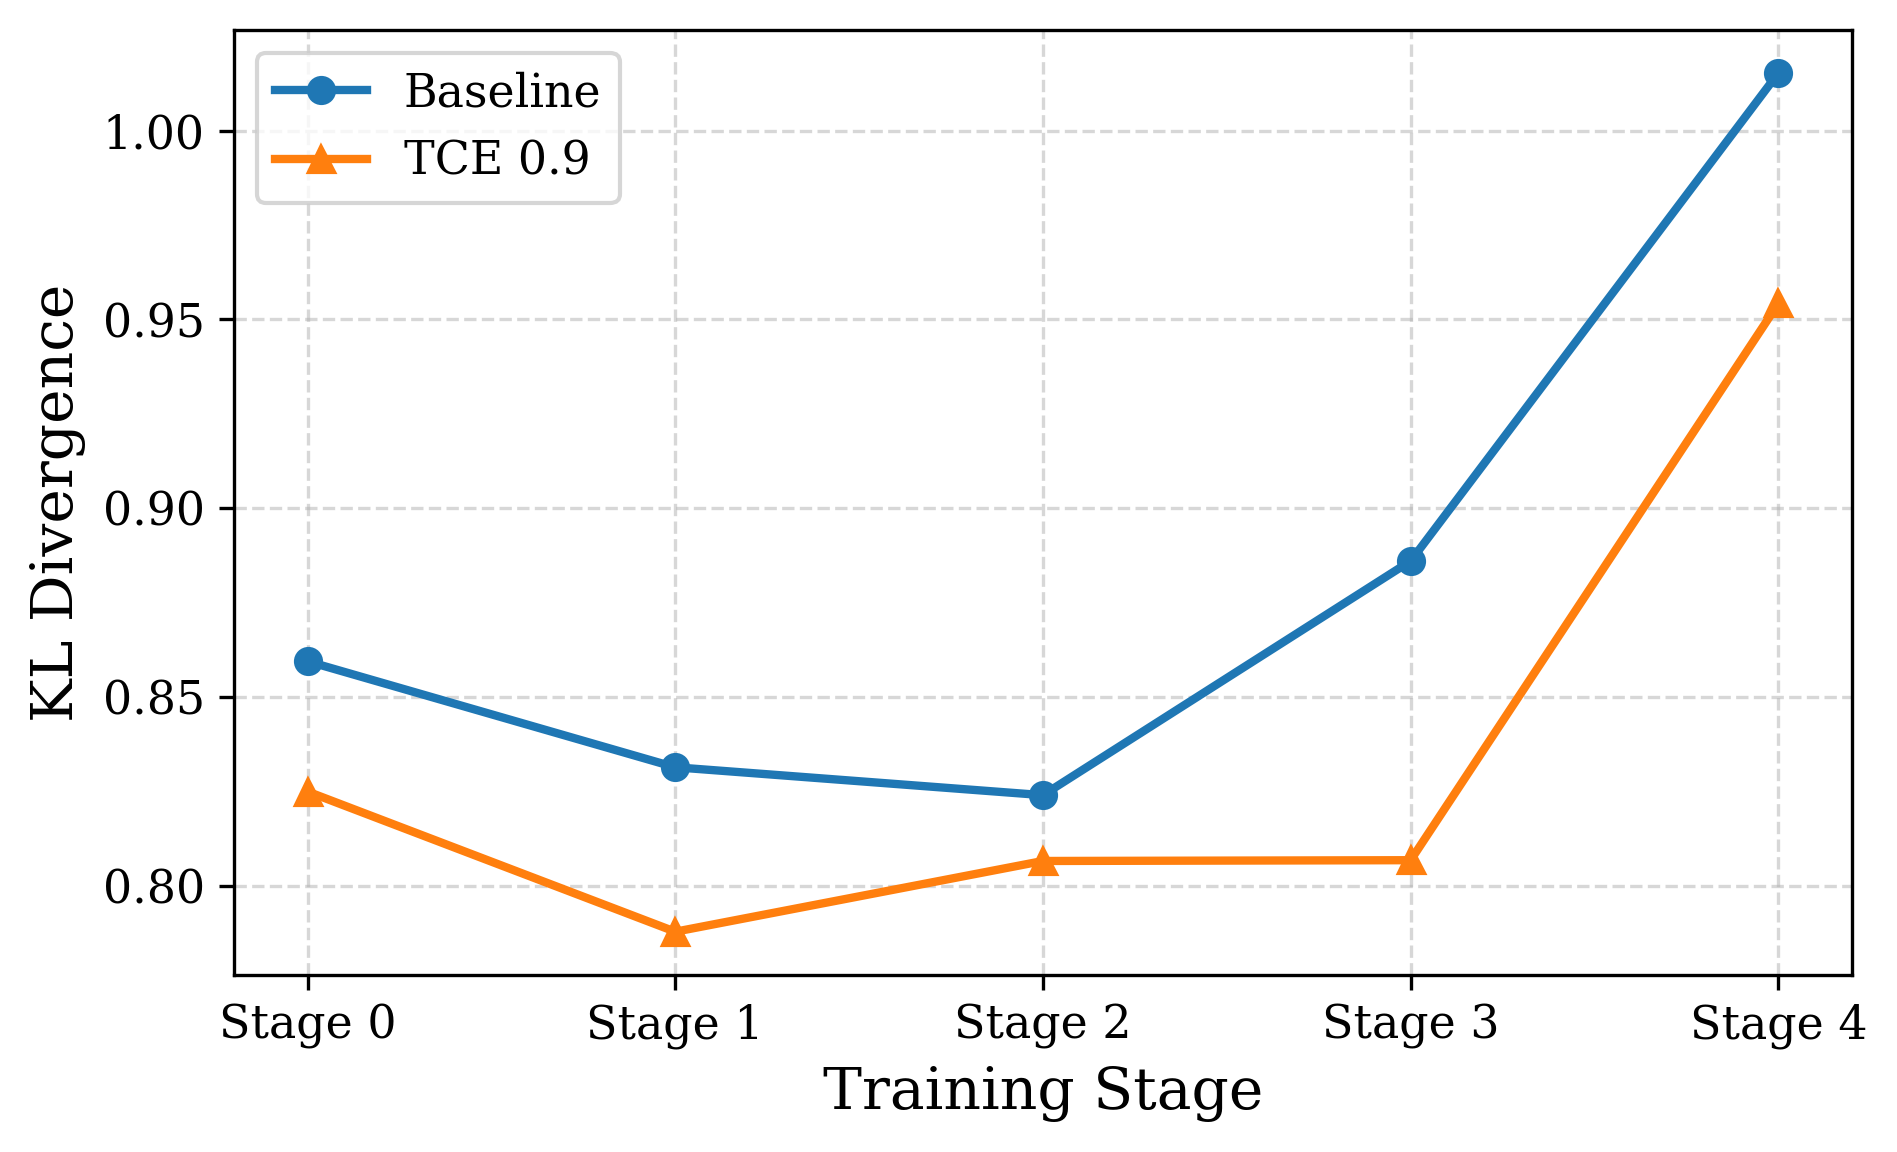

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Nature-style plot aesthetics
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 15,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.dpi": 300,
    "figure.figsize": (6.5, 4),
    "lines.linewidth": 2,
    "lines.markersize": 6,
})

# Example data; replace these with your actual results:

# Stages 0 to 4
N = 5
x = np.arange(N)
stage_labels = [f"Stage {i}" for i in x]

# Plot each method
plt.plot(x, llama_baseline[:N], label="Baseline", marker="o")
# plt.plot(x, llama_focal[:N],    label="Focal 2.0", marker="s")
plt.plot(x, llama_tce_9[:N],    label="TCE 0.9", marker="^")

# Axes labels and log-scale
# plt.yscale("log")
plt.xticks(x, stage_labels)
plt.xlabel("Training Stage")
plt.ylabel("KL Divergence")
# plt.title("KL Divergence: Synthetic vs. Wikitext Distributions (Gemma)")

# Grid, legend, layout
plt.grid(True, which="both", linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

plt.show()

# Optional: save as high-quality vector figure
# plt.savefig("kl_divergence_llama.png")